In [32]:
import numpy as np 
import pandas as pd
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy.stats import f_oneway
import pandas as pd
import datetime

In [33]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

# 원핫인코딩

### 데이터 전처리

In [34]:
# 데이터 불러오기
past_sales = pd.read_csv('C:/Users/PC/표/수요예측/rossmann-store-sales/train.csv')
store = pd.read_csv('C:/Users/PC/표/수요예측/rossmann-store-sales/store.csv')

# 데이터 제거
store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)

# 데이터 병합
data = pd.merge(left = past_sales,right = store, on = 'Store', how = 'right')

# 날짜
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")
data['Month']=pd.DatetimeIndex(data.Date).month
data['Day']=pd.DatetimeIndex(data.Date).day
data = data.drop(['Date'],axis=1)

# StateHoliday
data['StateHoliday'] = data['StateHoliday'].replace({0:'d'}) # 0 값은 d로 대체
data['StateHoliday'] = data['StateHoliday'].replace({'0':'d'})# 0 값은 d로 대체


# 결측값 처리
data = data.dropna(axis=0)

# store 이름 제거
data = data.drop(['Store'],axis=1)

# 데이터 분리(수치형, 범주형)
digital_cols = ['Sales', 'Customers', 'CompetitionDistance', 'Month', 'Day']
digital_data = data[digital_cols]
digital_data = pd.DataFrame(digital_data.values, columns = digital_cols)

# 표준화
scaler = StandardScaler().fit(digital_data)
digital_data = pd.DataFrame(scaler.transform(digital_data),index = digital_data.index, columns = digital_cols)

categorey_clos = data.columns.drop(digital_cols)
categorey_data = data[categorey_clos]
categorey_data = pd.DataFrame(categorey_data.values, columns = categorey_clos)

# 인코딩
onehotencoding_cols = ['StateHoliday', 'StoreType', 'Assortment', 'DayOfWeek']
categorey_data = pd.get_dummies(data = categorey_data, columns = onehotencoding_cols)

# 데이터 병합
data = pd.concat([digital_data, categorey_data], axis = 1)

pd.options.display.max_columns = None

C:\Users\PC\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [35]:
data

,Sales,Customers,CompetitionDistance,Month,Day,Open,Promo,SchoolHoliday,Promo2,StateHoliday_a,StateHoliday_b,StateHoliday_c,StateHoliday_d,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,-0.133481,-0.169168,-0.539198,0.346614,1.740763,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0
1,-0.196581,-0.188537,-0.539198,0.346614,1.626967,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0
2,-0.258383,-0.238037,-0.539198,0.346614,1.513171,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0
3,-0.198918,-0.158407,-0.539198,0.346614,1.399374,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0
4,0.084382,-0.046494,-0.539198,0.346614,1.285578,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014562,-0.261239,-0.634036,-0.010380,-1.457264,-1.217938,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0
1014563,-0.321223,-0.662014,-0.010380,-1.457264,-1.331734,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0
1014564,-0.384323,-0.717970,-0.010380,-1.457264,-1.445531,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0
1014565,-0.540124,-0.707209,-0.010380,-1.457264,-1.559327,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0


In [36]:
target_col = 'Sales'
features_cols = data.columns.drop(target_col)        
features = data[features_cols]
target = data[target_col]
target = pd.DataFrame(target.values.reshape(-1,1))
features = features.values
target = target.values
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.4, shuffle=False)
x_test,x_valid,y_test,y_valid = train_test_split(x_test, y_test, test_size=0.5, shuffle=False)

In [37]:
x_valid

array([[1.5288921138471578, -0.6791793109790012, -0.8559710445704234,
        ..., 0, 0, 0],
       [-1.3636204209963256, -0.6791793109790012, -0.8559710445704234,
        ..., 0, 0, 1],
       [0.2720265481115966, -0.6791793109790012, -0.8559710445704234,
        ..., 0, 1, 0],
       ...,
       [-0.7179703016116195, -0.010380081884059552, -1.4572636358890418,
        ..., 0, 0, 0],
       [-0.707209466288541, -0.010380081884059552, -1.4572636358890418,
        ..., 0, 0, 0],
       [-1.3636204209963256, -0.010380081884059552, -1.4572636358890418,
        ..., 0, 0, 0]], dtype=object)

In [40]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_valid = x_valid.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
y_valid = y_valid.astype(np.float32)

In [41]:
print('train_data의 row : %s, column : %s'%(x_train.shape[0],x_train.shape[1]))
print('test_data의 row : %s, column : %s'%(x_test.shape[0],x_test.shape[1]))
print('val_data의 row : %s, column : %s'%(x_valid.shape[0],x_valid.shape[1]))

train_data의 row : 608740, column : 26
test_data의 row : 202913, column : 26
val_data의 row : 202914, column : 26


### 학습

In [42]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(256,input_dim = x_train.shape[1],activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(256,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(256,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(128,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam',
             loss='mean_absolute_error',
             metrics=['mean_absolute_error'])

model_path = 'C:/project/rossmann-store-sales'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path , monitor='val_mean_absolute_error', verbose=1, save_best_only=True)
# early_stopping = EarlyStopping(monitor='val_loss', patience=6)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               6912      
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dense_12 (Dense)             (None, 256)              

In [43]:
start = datetime.datetime.now()

results= model.fit(x_train, y_train,
                    validation_data=(x_valid, y_valid),
                    batch_size=64,
                    epochs=50,
                   callbacks=[checkpoint])

end = datetime.datetime.now()
time = end-start
print("처리시간 : ", time)

Epoch 1/50
9510/9512 [============================>.] - ETA: 0s - loss: 0.2437 - mean_absolute_error: 0.2437
Epoch 00001: val_mean_absolute_error improved from inf to 0.19236, saving model to C:/project\rossmann-store-sales
INFO:tensorflow:Assets written to: C:/project\rossmann-store-sales\assets
9512/9512 [==============================] - 97s 10ms/step - loss: 0.2437 - mean_absolute_error: 0.2437 - val_loss: 0.1924 - val_mean_absolute_error: 0.1924
Epoch 2/50
9508/9512 [============================>.] - ETA: 0s - loss: 0.2146 - mean_absolute_error: 0.2146
Epoch 00002: val_mean_absolute_error did not improve from 0.19236
9512/9512 [==============================] - 98s 10ms/step - loss: 0.2146 - mean_absolute_error: 0.2146 - val_loss: 0.1964 - val_mean_absolute_error: 0.1964
Epoch 3/50
9506/9512 [============================>.] - ETA: 0s - loss: 0.2097 - mean_absolute_error: 0.2097
Epoch 00003: val_mean_absolute_error did not improve from 0.19236
9512/9512 [===========================

Epoch 25/50
9506/9512 [============================>.] - ETA: 0s - loss: 0.1961 - mean_absolute_error: 0.1961
Epoch 00025: val_mean_absolute_error did not improve from 0.19187
9512/9512 [==============================] - 88s 9ms/step - loss: 0.1961 - mean_absolute_error: 0.1961 - val_loss: 0.2091 - val_mean_absolute_error: 0.2091
Epoch 26/50
9507/9512 [============================>.] - ETA: 0s - loss: 0.1959 - mean_absolute_error: 0.1959
Epoch 00026: val_mean_absolute_error did not improve from 0.19187
9512/9512 [==============================] - 74s 8ms/step - loss: 0.1959 - mean_absolute_error: 0.1959 - val_loss: 0.2048 - val_mean_absolute_error: 0.2048
Epoch 27/50
9511/9512 [============================>.] - ETA: 0s - loss: 0.1949 - mean_absolute_error: 0.1949
Epoch 00027: val_mean_absolute_error did not improve from 0.19187
9512/9512 [==============================] - 83s 9ms/step - loss: 0.1949 - mean_absolute_error: 0.1949 - val_loss: 0.2216 - val_mean_absolute_error: 0.2216
Epoc

Epoch 50/50
9512/9512 [==============================] - ETA: 0s - loss: 0.1919 - mean_absolute_error: 0.1919
Epoch 00050: val_mean_absolute_error did not improve from 0.19187
9512/9512 [==============================] - 89s 9ms/step - loss: 0.1919 - mean_absolute_error: 0.1919 - val_loss: 0.2127 - val_mean_absolute_error: 0.2127
처리시간 :  1:17:49.114252


### 평가 : 테스트 데이터로

In [49]:
pred= model.predict(x_valid)

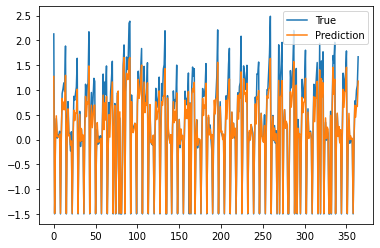

In [52]:
pred_365 = pred[0:365]
y_test_365 = y_valid[0:365]

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test_365, label='True')
ax.plot(pred_365, label='Prediction')

ax.legend()
plt.show()

In [53]:
from sklearn.metrics import r2_score
r2 = r2_score(pred, y_valid)
print(r2)

0.7756599524604825
